In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeClassifier

### Wczytanie danych oraz sprawdzenie ich kształtu i poprawności ich wczytania

In [2]:
dane = pd.read_csv('Data_churn.csv', sep=";", decimal=",", na_values=" ")
dane.shape

(7043, 25)

In [3]:
dane.head()

,City,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,Los Angeles,Male,No,No,No,2,Yes,No,DSL,Yes,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,Friant,Female,No,No,No,10,Yes,Yes,Fiber optic,No,...,Month-to-month,Yes,Electronic check,98.50,1058.25,Yes,1,74,5184,Attitude of service provider
2,Kerman,Male,No,No,No,6,Yes,No,Fiber optic,No,...,Month-to-month,Yes,Electronic check,85.35,489.45,Yes,1,75,4694,Attitude of service provider
3,Orosi,Female,No,No,No,2,Yes,No,Fiber optic,No,...,Month-to-month,Yes,Mailed check,86.20,178.70,Yes,1,95,2969,Attitude of service provider
4,Fresno,Male,No,Yes,No,21,Yes,Yes,Fiber optic,No,...,Month-to-month,Yes,Electronic check,111.20,2317.10,Yes,1,89,4123,Attitude of service provider


### Sprawdzenie missing values

In [4]:
dane.isna().sum()

City                    0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges          11
Churn Label             0
Churn Value             0
Churn Score             0
CLTV                    0
Churn Reason         5174
dtype: int64

Usunięcie kolumn
- **Churn Reason** - Bardzo duża ilość brakujących danych
- **Churn Label** - Powtórzenie kolumny

Oraz porzucenie obserwacji z pustymi obszarami danych. Czyli tych 11 obserwacji, które mają braki danych w atrybucie **Total Charges**

In [5]:
dane = dane.drop(['Churn Reason', 'Churn Label'], axis=1)
dane = dane.dropna()

In [6]:
# sprawdzenie danych po usunięciu
dane.shape

(7032, 23)

### Sprawdzenie typu zmiennych i postawowych wskaźników atrybutów numerycznych

In [7]:
dane.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   City               7032 non-null   object 
 1   Gender             7032 non-null   object 
 2   Senior Citizen     7032 non-null   object 
 3   Partner            7032 non-null   object 
 4   Dependents         7032 non-null   object 
 5   Tenure Months      7032 non-null   int64  
 6   Phone Service      7032 non-null   object 
 7   Multiple Lines     7032 non-null   object 
 8   Internet Service   7032 non-null   object 
 9   Online Security    7032 non-null   object 
 10  Online Backup      7032 non-null   object 
 11  Device Protection  7032 non-null   object 
 12  Tech Support       7032 non-null   object 
 13  Streaming TV       7032 non-null   object 
 14  Streaming Movies   7032 non-null   object 
 15  Contract           7032 non-null   object 
 16  Paperless Billing  7032 

In [8]:
dane.describe(percentiles=[0.1, 0.5, 0.9]).round(2)

,Tenure Months,Monthly Charges,Total Charges,Churn Value,Churn Score,CLTV
count,7032.00,7032.00,7032.00,7032.00,7032.00,7032.00
mean,32.42,64.80,2283.30,0.27,58.72,4401.45
std,24.55,30.09,2266.77,0.44,21.53,1182.41
min,1.00,18.25,18.80,0.00,5.00,2003.00
10%,2.00,20.05,84.60,0.00,28.00,2613.00
50%,29.00,70.35,1397.48,0.00,61.00,4527.50
90%,69.00,102.65,5976.64,1.00,87.00,5865.00
max,72.00,118.75,8684.80,1.00,100.00,6500.00


### Mapa cieplna korelacji zmiennych numerczynych 

<AxesSubplot:>

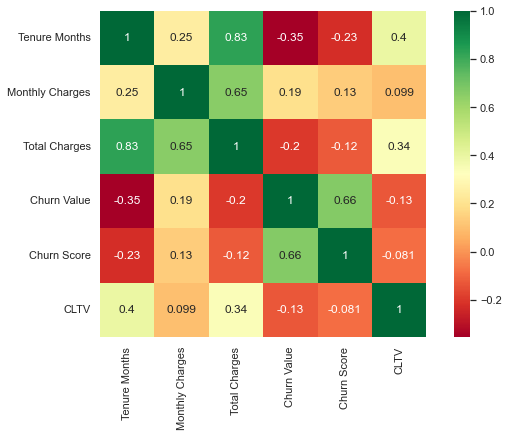

In [9]:
sns.set(rc={'figure.figsize':(10, 6)})
sns.heatmap(dane.corr(), square=True, cmap='RdYlGn', annot=True)

### Współczynnik determinacji
Aby sprawdzić jak poszczególne atrybuty wpływają na zmienną objaśnianą. Aby to zobaczyć wszystkie wartości zostały zmienione na wartości numeryczne. Nastepnie dane zostały już zapisane do użycia dalej za pomocą modułu `pickle`. Do wyznaczenia współczynnika przemnożyłem przez siebie korelacje wyznaczone za pomocą metody `corr()`. Interesuje nas najbardziej jak wpływają atrybuty na zmienną objaśnianą przez co współczynnik jest pokazany tylko w stosunku do tej zmiennej.

In [10]:
dane = dane.replace("Yes", 1)
dane = dane.replace("No", 0)
dane = dane.replace("No internet service", 0)
dane = dane.replace("Fiber optic", 0)
dane = dane.replace("Multiple Lines", 0)
dane = dane.replace("No phone service", 0)
dane = dane.replace("Male", 1)
dane = dane.replace("Female", 0)
dane = dane.replace("DSL", 1)
dane = dane.replace("Month-to-month", 1)
dane = dane.replace("Two year", 2)
dane = dane.replace("One year", 3)
dane = dane.replace("Mailed check", 1)
dane = dane.replace("Electronic check", 2)
dane = dane.replace("Credit card (automatic)", 3)
dane = dane.replace("Bank transfer (automatic)", 4)

In [11]:
dane.to_pickle("Data_allnum.pkl")

In [12]:
cor_val = dane.corr()
cor_val = cor_val[['Churn Value']]
cor_val = round(cor_val * cor_val,2)
cor_val = cor_val.drop("Churn Value", axis=0)

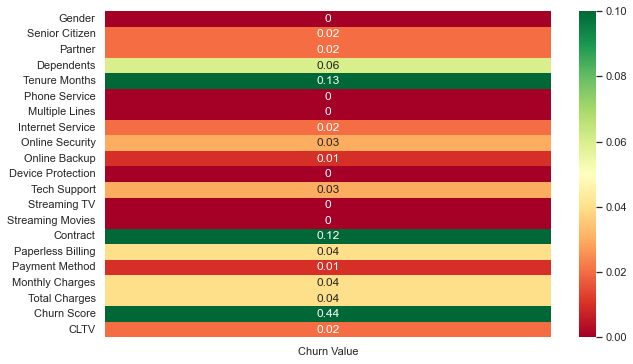

In [13]:
sns.heatmap(cor_val, cmap='RdYlGn', vmax=0.1, vmin=0.0, annot=True)
plt.show()

Na wykresie możemy zobaczyć, że jest dużo zmiennych, które w żadnym stopniu nie opisują zmiennej objaśnianej. Można by usunąć je z danych aby nie przedłużały późniejszych obliczeń, natmiast w ramach uproszczenia pozostawie je w danych i model sam zdecyduje czy będzie ich używać czy też je wyzeruje.

### Obserwacje odstające
W ramach sprawdzenia obserwacji odstających zostały utworzone wykresy pudełkowe, które w razie pojawienia się takich obserwacji oznacza je. Zostały one utworzone tylko dla wartości domyślnie numercznych bo oczywiście dla sztucznie utworzonych nie ma sensu tego przeprowadzać.

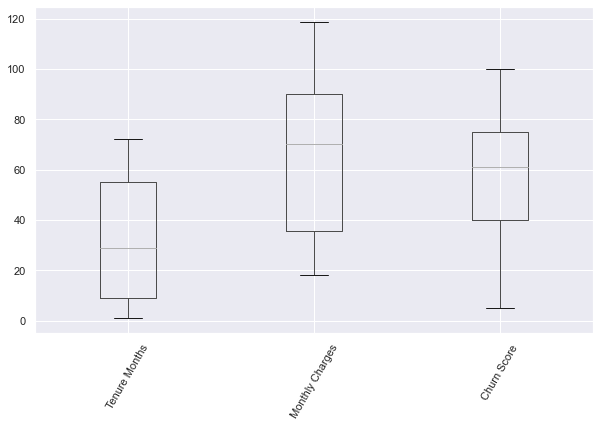

In [14]:
dane[['Tenure Months', 'Monthly Charges', "Churn Score"]].boxplot(rot=60)
plt.show()

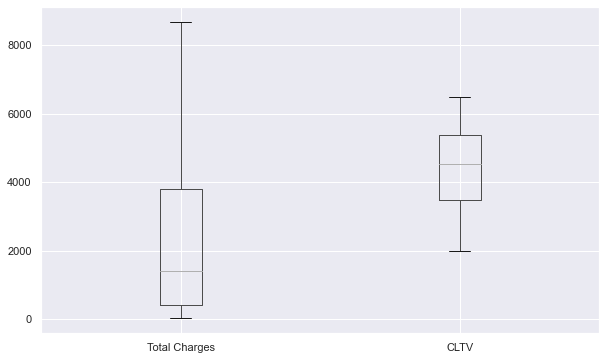

In [15]:
dane[['Total Charges', "CLTV"]].boxplot()
plt.show()

Na wykresie nie zostały żadne punkty, które symbolizują operacje odstające, z tego powodu można uznać, że w naszych danych takich obserwacji nie ma.

### Sprawdzenie ważności atrybutów przez model drzewa decyzyjnego
W ramach ostatecznego sprawdzenia, zobaczę jeszcze jak drzewo decyzyjne podchodzi do oznaczenia ważności atrybutów i których współczynniki maksymalizuje a które minimalizuje

In [16]:
X_col = dane.drop(['Churn Value', 'Churn Score'], axis=1).select_dtypes(np.int64).columns
X = dane.drop(['Churn Value', 'Churn Score'], axis=1).select_dtypes(np.int64).values
y = dane['Churn Value'].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

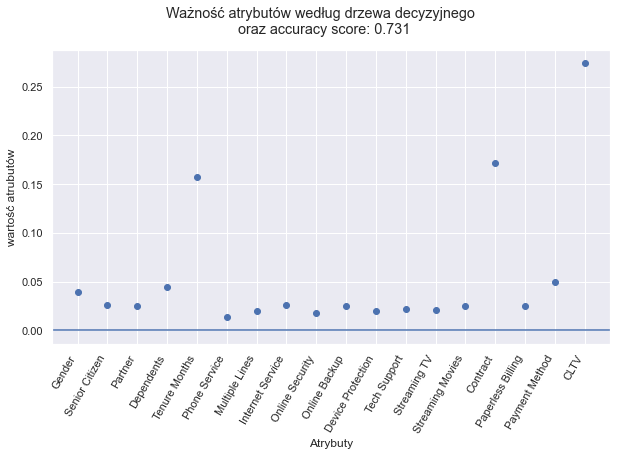

In [17]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
importance = tree.feature_importances_

fig, ax = plt.subplots()

ax.scatter(X_col, importance)
ax.set_ylabel("wartość atrubutów")
ax.set_xlabel("Atrybuty")
ax.axhline(0)

fig.autofmt_xdate(rotation=60)
fig.suptitle(f"Ważność atrybutów według drzewa decyzyjnego \n oraz accuracy score: {round(tree.score(X_test, y_test), 3)}")

plt.show()

Możemy zobaczyć, że model wybrał sobie 3 faworytów i są to **Tenure Months**, **Contract** i **CLTV**. Model ten też całkiem trafnie predykuje wartość Churn-a. Oczywiście natomiast powinno zostać sprawdzone pozostałe wartości oceniające model takie jak recall czy precision nastomiast będzie to przeprowadzane już w późniejszej części.